In [319]:
import pandas as pd
import pyodbc
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder



In [320]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    return pd.read_sql(query, sql_conn)

In [321]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'


#Stores the result in a pandas DataFrame object called data
query ="SELECT ISNULL(ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, FillerOrder.fillerOrderStatusCd, PL.locationName, BUCKETS.BUCKETNUM FROM BUCKETS LEFT JOIN ProcedureStep ON BUCKETS.PSKEY = ProcedureSteP.procedureStepKey LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
original = getData(server, UID, PWD, database,query)
data = original.copy()


query ="SELECT DISTINCT ISNULL(ProcedureStep.subSpecialtyCd, 'UNKNOWN') as subSpecialtyCd FROM ProcedureStep"
subSpecialtyCd = getData(server, UID, PWD, database, query)

query ="SELECT DISTINCT ISNULL(PL.locationName, 'UNKNOWN') as locationName FROM FillerOrder LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
locationNameCd = getData(server, UID, PWD, database, query)

query ="SELECT DISTINCT FillerOrder.fillerOrderStatusCd FROM FillerOrder"
fillerOrderStatusCd = getData(server, UID, PWD, database, query)

bucketNumCd = [1,2,3,4,5]
bucketNumCd = np.asarray(bucketNumCd)

In [322]:
#data1['BUCKETNUM'] = data1.BUCKETNUM.apply(lambda x: x - 1)
data['subSpecialtyCd'] = data.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data['fillerOrderStatusCd'] = data.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data['locationName'] = data.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data['BUCKETNUM'] = data.BUCKETNUM.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [323]:
data

,subSpecialtyCd,fillerOrderStatusCd,locationName,BUCKETNUM
0,14,3,1,2
1,5,3,1,2
2,13,0,1,4
3,4,0,1,4
4,2,0,1,4
5,7,3,1,0
6,4,3,15,1
7,7,3,1,0
8,7,3,1,0
9,5,3,15,1


In [324]:
x = data[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName' ]]
y = data[['BUCKETNUM']]

In [327]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = .1, random_state = 40)



In [328]:
X_train.shape

(9000, 3)

In [329]:
def create_model(max_words, maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length to what we have already
    #configured for our vectorized forms of our text
    model.add(Embedding(input_dim = max_words, input_length=maxlen, output_dim = 50))
    
    #model.add(Embedding(max_words,50, input_length=maxlen, embeddings_initializer="uniform"))
    
    #add a bidirectional LSTM layer with 32 units
    model.add(Bidirectional(LSTM(units =32)))
    
    #model.add(Conv1D(maxlen, 1, padding='valid', activation='relu', strides=1))
    #model.add(GlobalMaxPool1D())
    
    # create a dense output layer with the units = len(labels_dict)
    model.add(Dense(5, activation='softmax'))
    
    #print the summary
    model.summary()
    
    return model

In [343]:
model = create_model(20, 3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 3, 50)             1000      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 64)                21248     
_________________________________________________________________
dense_14 (Dense)             (None, 5)                 325       
Total params: 22,573
Trainable params: 22,573
Non-trainable params: 0
_________________________________________________________________


In [344]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> rmsprop (standard)
    #loss -> sparse categorical crossentropy (because we have a large multiclassifcation probelm)
    #meteric -> accuracy
    model.compile(optimizer='rmsprop',
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model 
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0.1)
    return history

In [367]:
#train the model
history = train_model(model, X_train, Y_train.values, 10, 500, 20, 3)

Train on 8100 samples, validate on 900 samples
Epoch 1/10
8100/8100 [==============================] - 6s 756us/step - loss: 0.0271 - acc: 0.9938 - val_loss: 0.0167 - val_acc: 0.9989
Epoch 2/10
8100/8100 [==============================] - 0s 30us/step - loss: 0.0136 - acc: 0.9998 - val_loss: 0.0103 - val_acc: 0.9989
Epoch 3/10
8100/8100 [==============================] - 0s 32us/step - loss: 0.0077 - acc: 0.9998 - val_loss: 0.0072 - val_acc: 0.9989
Epoch 4/10
8100/8100 [==============================] - 0s 29us/step - loss: 0.0045 - acc: 0.9998 - val_loss: 0.0051 - val_acc: 0.9989
Epoch 5/10
8100/8100 [==============================] - 0s 35us/step - loss: 0.0027 - acc: 0.9998 - val_loss: 0.0040 - val_acc: 0.9989
Epoch 6/10
8100/8100 [==============================] - 0s 29us/step - loss: 0.0016 - acc: 0.9999 - val_loss: 0.0038 - val_acc: 0.9989
Epoch 7/10
8100/8100 [==============================] - 0s 34us/step - loss: 0.0011 - acc: 0.9999 - val_loss: 0.0036 - val_acc: 0.9989
Epoch 8

In [368]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    #display the max values we attained
    print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
    print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

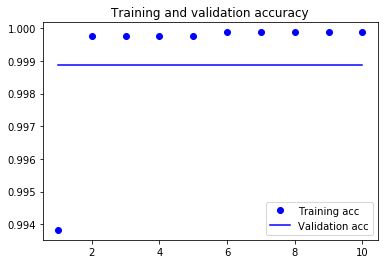

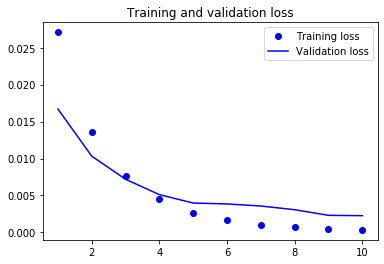

Validation Accuracy:  99.88889031940036
Training Accuracy:  99.98765447993337


In [369]:
training_report(history)

In [370]:
#test the model on our set aside testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a percent for every bucket at how confident the model is for 
    #each bucket. 
    
    #the highest percent in our case the the bucket the model has choosen
    preds = model.predict(x_test)
    
    y_pred = []
    
    #for ever row in the prediction list
    #grab the max value and append that index to the y_pred
    for row in preds:
        y_pred.append(np.argmax(row))
    
    #convert the list to a numpy array
    return np.asarray(y_pred)

In [371]:
#test the model against our test data and store the predictions in y_pred
y_pred = test_model(model, X_test)

In [372]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    print(confusion_matrix(y_test, y_pred))

In [373]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(classification_report(y_test, y_pred))

In [374]:
test_confusion_matrix(y_pred,Y_test)

[[315   0   0   0   0]
 [  0 159   0   0   1]
 [  0   0 275   0   0]
 [  0   0   0 155   0]
 [  0   0   0   0  95]]


In [375]:
#display the classification report on the predictions
test_classification_report(y_pred, Y_test)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       315
           1       1.00      0.99      1.00       160
           2       1.00      1.00      1.00       275
           3       1.00      1.00      1.00       155
           4       0.99      1.00      0.99        95

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [376]:
#Stores the result in a pandas DataFrame object called data
query ="SELECT ISNULL(ProcedureStep.subSpecialtyCd,'UNKNOWN') AS subSpecialtyCd, FillerOrder.fillerOrderStatusCd, PL.locationName, BUCKETS1.BUCKETNUM FROM BUCKETS1 LEFT JOIN ProcedureStep ON BUCKETS1.PSKEY = ProcedureSteP.procedureStepKey LEFT JOIN RequestedProcedure ON ProcedureStep.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN LOCATION AS PL ON FillerOrder.scheduledLocationKey = PL.locationKey"
original1 = getData(server, UID, PWD, database,query)
data1 = original1.copy()

In [377]:
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,BUCKETNUM
0,*GP,F,Holy Family Hospital - Incyte,3
1,*GYP,F,InCyte Diagnostics Walla Walla,4
2,*GYP,F,InCyte Diagnostics Walla Walla,4
3,*GP,F,Kadlec Medical Center,3
4,*OP,F,InCyte Diagnostics Spokane,3
5,*GYP,F,InCyte Diagnostics Walla Walla,4
6,*GIP,F,Holy Family Hospital - Incyte,3
7,*GYP,F,InCyte Diagnostics Walla Walla,4
8,*GYP,F,InCyte Diagnostics Walla Walla,4
9,*GYP,F,InCyte Diagnostics Walla Walla,4


In [378]:
data1['subSpecialtyCd'] = data1.subSpecialtyCd.apply(lambda x: np.where(subSpecialtyCd.values == x)[0][0])
data1['fillerOrderStatusCd'] = data1.fillerOrderStatusCd.apply(lambda x: np.where(fillerOrderStatusCd.values == x)[0][0])
data1['locationName'] = data1.locationName.apply(lambda x: np.where(locationNameCd.values == x)[0][0])
data1['BUCKETNUM'] = data1.BUCKETNUM.apply(lambda x: np.where(bucketNumCd == x)[0][0])

In [379]:
data1

,subSpecialtyCd,fillerOrderStatusCd,locationName,BUCKETNUM
0,5,3,18,2
1,7,3,16,3
2,7,3,16,3
3,5,3,12,2
4,14,3,1,2
5,7,3,16,3
6,4,3,18,2
7,7,3,16,3
8,7,3,16,3
9,7,3,16,3


In [380]:
x_test = data1[['subSpecialtyCd', 'fillerOrderStatusCd', 'locationName' ]]
y_test = data1[['BUCKETNUM']]

In [381]:
#test the model against our test data and store the predictions in y_pred
Y_pred = test_model(model, x_test)

In [382]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    print(confusion_matrix(y_test, y_pred))

In [383]:
#create the classification report
def test_classification_report(y_pred,y_test):
    print(classification_report(y_test, y_pred))

In [384]:
test_confusion_matrix(Y_pred,y_test)

[[0 0 0]
 [3 1 0]
 [0 0 6]]


In [385]:
#display the classification report on the predictions
test_classification_report(Y_pred, y_test)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.25      0.40         4
           3       1.00      1.00      1.00         6

    accuracy                           0.70        10
   macro avg       0.67      0.42      0.47        10
weighted avg       1.00      0.70      0.76        10



In [386]:
Y_pred

array([1, 3, 3, 1, 2, 3, 1, 3, 3, 3], dtype=int64)